# c-GAN

In [327]:
import torch
import torch.nn as nn
from torch.nn import init
import torchsummary
import torchvision
import torchvision.transforms as T
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as dset
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

import math
import os


# for plotting
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['font.size'] = 16
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Dataset

In [328]:
def show_images(images):
    images = torch.reshape(
        images, [images.shape[0], -1]
    )  # images reshape to (batch_size, D)
    sqrtn = int(math.ceil(math.sqrt(images.shape[0])))
    sqrtimg = int(math.ceil(math.sqrt(images.shape[1])))
    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis("off")
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect("equal")
        plt.imshow(img.reshape([sqrtimg, sqrtimg]))
    return

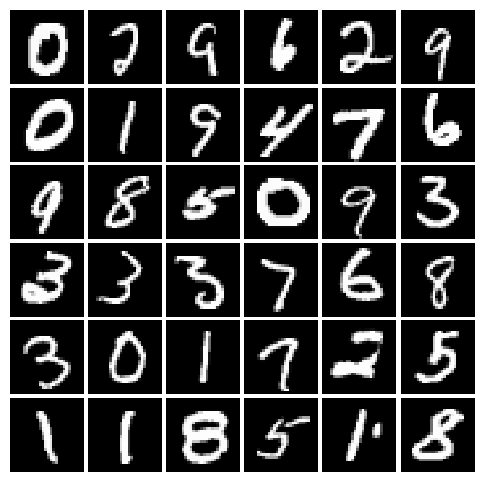

In [329]:
batch_size = 128
mnist_train = dset.MNIST('../datasets', train=True, download=True, transform=T.ToTensor())
loader_train = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=2)
imgs = next(loader_train.__iter__())[0].view(batch_size, 784)
show_images(imgs[:36])

# Generative Autoencoder

## Discriminator

In [330]:
class Discriminator(nn.Module):
  def __init__(self):
    super().__init__()
    self.embedding_layer = nn.Embedding(10, 10)
    self.linear_layer = nn.Linear(10, 28 * 28 * 1)
    self.width = 28
    self.height = 28
    self.layers = nn.Sequential(
      nn.Unflatten(1, (1, self.height * 2, self.width)),
      nn.Conv2d(1, 32, 5),
      nn.LeakyReLU(negative_slope=0.01),
      nn.MaxPool2d(2, stride=2),
      nn.Conv2d(32, 64, 5),
      nn.LeakyReLU(negative_slope=0.01),
      nn.MaxPool2d(2, stride=2),
      nn.Flatten(),
      nn.Linear(11 * 4 * 64, 11 * 4 * 64),
      nn.LeakyReLU(negative_slope=0.01),
      nn.Linear(11 * 4 * 64, 1)
    )

  def forward(self, input_distribution, labels):
    logits = None
    labels = self.embedding_layer(labels)
    labels = self.linear_layer(labels)
    input_distribution = torch.cat([input_distribution, labels], 1)
    logits = self.layers(input_distribution)
    return logits  

Input a random sample with shape `(32, 784)` to a discriminator and check if the output is `(32,1)`. 

In [331]:
labels = torch.LongTensor(np.random.randint(0, 10, 32))
discriminator = Discriminator()
input = torch.rand(32, 784)
output = discriminator(input, labels)
print(input.size())
print(output.size())

torch.Size([32, 784])
torch.Size([32, 1])


## Generator

In [332]:
class Generator(nn.Module):
    def __init__(self, noise_dim):
        super().__init__()
        self.embedding_layer = nn.Embedding(10, 10)
        self.layers = nn.Sequential(
          nn.Linear(noise_dim + 10, 1024),
          nn.ReLU(),
          nn.BatchNorm1d(1024),
          nn.Linear(1024, 7 * 7 * 128),
          nn.ReLU(),
          nn.BatchNorm1d(7 * 7 * 128),
          nn.Unflatten(1, (128, 7, 7)),
          nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
          nn.ReLU(),
          nn.BatchNorm2d(64),
          nn.ConvTranspose2d(64, 1, 4, stride=2, padding=1),
          nn.Tanh(),
          nn.Flatten()
        )

    def forward(self, random_noise, labels):
        fake_image = None
        labels = self.embedding_layer(labels)
        random_noise = torch.cat([random_noise, labels], 1)
        fake_image = self.layers(random_noise)
        return fake_image

Input a random sample with shape `(32, 96)` to a Generator and check if the output is `(32, 784)`. 

In [333]:
labels = torch.LongTensor(np.random.randint(0, 10, 32))
generator = Generator(noise_dim=96)
input = torch.rand(32, 96)
output = generator(input, labels)
print(input.size())
print(output.size())

torch.Size([32, 96])
torch.Size([32, 784])


## GAN Loss

### Discriminator Loss

In [334]:
def Discriminator_Loss(logits_real, logits_fake, device='cuda', dtype=torch.float):
    loss = None
    true_labels = torch.ones(logits_real.size(), dtype=dtype, device=device)
    fake_labels = torch.zeros(logits_fake.size(), dtype=dtype, device=device)
    loss_real = nn.functional.binary_cross_entropy_with_logits(logits_real, true_labels)
    loss_fake = nn.functional.binary_cross_entropy_with_logits(logits_fake, fake_labels)
    loss = loss_real + loss_fake
    return loss

### Generator Loss

In [335]:
def Generator_Loss(logits_fake, device='cuda', dtype=torch.float):
    loss = None
    true_labels = torch.ones(logits_fake.size(), dtype=dtype, device=device)
    loss = nn.functional.binary_cross_entropy_with_logits(logits_fake, true_labels)
    return loss

## Weight initializer

In [336]:
def initialize_weights(m):
    """Initializes the weights of a torch.nn model using xavier initialization"""
    if isinstance(m, nn.Linear) or isinstance(m, nn.ConvTranspose2d):
        nn.init.xavier_uniform_(m.weight.data)

## GAN Training

In [337]:
def generate_random_noise_in_range(shape, r1, r2, dtype, device):
  return (r1 - r2) * torch.rand(shape, dtype=dtype, device=device) + r2

In [401]:
generator_state_dict_path = '../models/cGAN-generator.pth'

batch_size = 128
num_epochs = 50
latent_dim = 96
learning_rate = 0.001

dtype = torch.float
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'DEVICE USED: {device}')

if os.path.isfile(generator_state_dict_path):
    # resuing pre-trained generator
    print('Found a pre-trained generator')
    generator = Generator(noise_dim=latent_dim).to(device)
    generator.load_state_dict(torch.load(generator_state_dict_path))
else:    
    # training model from scratch
    print('Did not find a pre-trained generator. Retraining from scratch')

    discriminator = Discriminator().apply(initialize_weights).to(device)
    generator = Generator(latent_dim).apply(initialize_weights).to(device)

    optimizer_discriminator = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
    optimizer_generator = optim.Adam(generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))

    for epoch in range(num_epochs):
        print(f'Training Epoch: {epoch}')
        for x, real_labels in loader_train:
            # Drop the last batch with irregular size to simplify the code
            if len(x) != batch_size:
              continue
            # numerical trick to increase distance between digit pixels and empty pixels
            real_data = x.view(-1, 784).to(device)
            real_data = 2 * (real_data - 0.5)
            real_labels = real_labels.to(device)

            # DISCRIMINATOR PART
            discriminator.zero_grad()
            logits_real = discriminator(real_data, real_labels)
            random_noise = generate_random_noise_in_range((batch_size, latent_dim), r1=-1, r2=1, dtype=dtype, device=device)
            if device == 'cuda':
                fake_labels = torch.cuda.LongTensor(np.random.randint(0, 10, batch_size))
            else:
                fake_labels = torch.LongTensor(np.random.randint(0, 10, batch_size))
            fake_data = generator(random_noise, fake_labels)
            # detach the gradients so that the Generator's gradients are not optimized in this training phase
            logits_fake = discriminator(fake_data.detach(), fake_labels.detach())
            discriminator_loss = Discriminator_Loss(logits_real, logits_fake, device, dtype)
            discriminator_loss.backward()
            optimizer_discriminator.step()

            # GENERATOR PART
            generator.zero_grad()
            random_noise = generate_random_noise_in_range((batch_size, latent_dim), r1=-1, r2=1, dtype=dtype, device=device)
            if device == 'cuda':
                fake_labels = torch.cuda.LongTensor(np.random.randint(0, 10, batch_size))
            else:
                fake_labels = torch.LongTensor(np.random.randint(0, 10, batch_size))
            fake_data = generator(random_noise, fake_labels)
            logits_fake = discriminator(fake_data, fake_labels)
            generator_loss = Generator_Loss(logits_fake, device, dtype)
            generator_loss.backward()
            optimizer_generator.step()
    torch.save(generator.state_dict(), generator_state_dict_path)

DEVICE USED: cuda
Found a pre-trained generator


## Visualization Functions


In [402]:
def write_numbers(number_array):
    generated_images = torch.Tensor()
    for number in number_array:
        generator.eval()
        input_noise = generate_random_noise_in_range((1, latent_dim), r1=-1, r2=1, dtype=dtype, device=device)
        if device == 'cuda':
            label = torch.cuda.LongTensor([number,])
        else:
            label = torch.LongTensor([number,])
        with torch.no_grad():
            generated_image  = generator(input_noise, label).to('cpu')
        generated_images = torch.cat((generated_images, generated_image), 0)
    
    n = len(number_array)
    image_dim = int(math.ceil(math.sqrt(generated_images.shape[1])))
    fig = plt.figure(figsize=(1, n))
    gs = gridspec.GridSpec(1, n)
    gs.update(wspace=0.0, hspace=0.0, top=1.0, bottom=0.0, left=0.0, right=n)

    for i, img in enumerate(generated_images):
        ax = plt.subplot(gs[i])
        plt.axis("off")
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect("equal")
        plt.imshow(img.reshape([image_dim, image_dim]))
    return

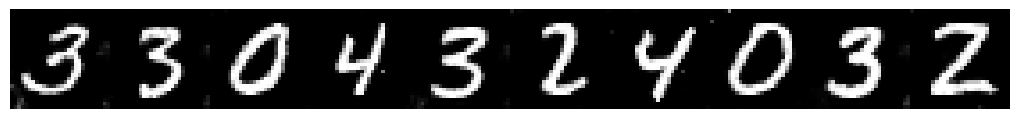

In [403]:
numbers = np.random.randint(10, size=10)
write_numbers(numbers)

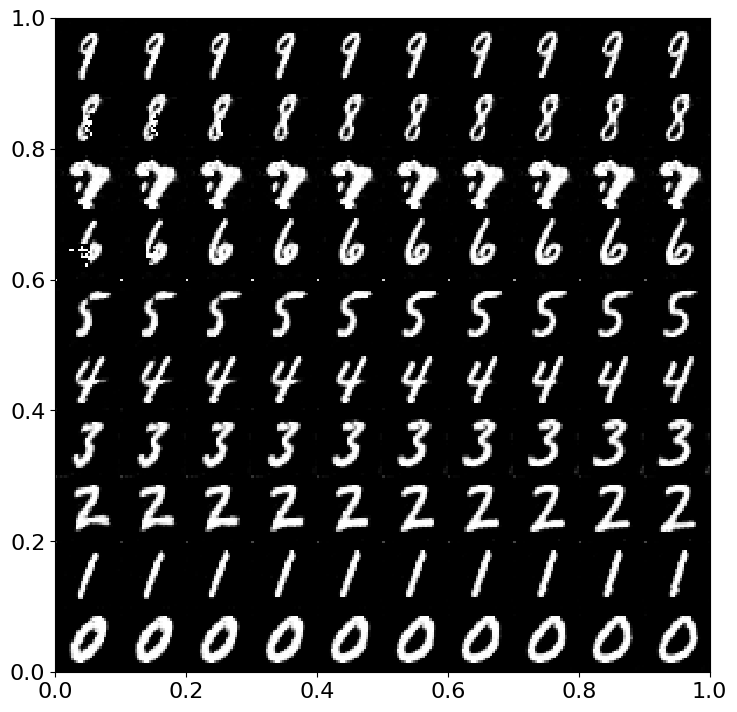

In [405]:
n = 10
interpolation_range = (0.0, 1.0)
z1 = generate_random_noise_in_range((1, latent_dim), r1=-1, r2=1, dtype=dtype, device=device)
z2 = generate_random_noise_in_range((1, latent_dim), r1=-1, r2=1, dtype=dtype, device=device)
r1_samples = np.linspace(*interpolation_range, num=n)
r2_samples = np.linspace(*interpolation_range, num=n)
plt.figure(figsize=(20,8.5))
w = 28
img = np.zeros((n*w, n*w))
for i, r1 in enumerate(r1_samples):
    for j, r2 in enumerate(r2_samples):
        z_interpolate = torch.mul(z1, r1) + torch.mul(z2, 1 - r2)
        labels = torch.cuda.LongTensor([i])
        with torch.no_grad():
          generated_image = generator(z_interpolate, labels).cpu().view(28, 28)
        img[(n - 1 - i) * w : (n - 1 - i + 1) * w, j * w : (j + 1) * w] = generated_image
plt.imshow(img, extent=[*interpolation_range, *interpolation_range], cmap='gist_gray')